<center> Macroentrenamiento en Inteligencia Artificial (MeIA) 2025 <center>
<center> Módulo 2 <center>
<center>Especialización en Procesamiento de Lenguaje Natural<center>
<center>Transformers<center>
<center> Miguel Ángel Álvarez Carmona <center>


Investigador

SECIHTI - CIMAT Mty

miguel.alvarez@cimat.mx

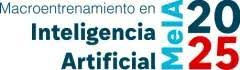

### Comprobamos la GPU asignada

In [ ]:
! nvidia-smi

Fri Jun 13 16:19:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Autenticación en HF (para compartir modelo)

Para poder compartir nuestro modelo con la comunidad y generar resultados como el que se muestra en la imagen de arriba a través de la API de inferencia, hay algunos pasos más a seguir.

Primero debe almacenar su token de autenticación del sitio web HuggingFace (regístrate [aquí] (https://huggingface.co/join) si aún no lo ha hecho), luego ejecute la siguiente celda e ingrese su nombre de usuario y contraseña:

### Instalamos las dependencias requeridas

In [ ]:
!pip install datasets
!pip install transformers==4.28.0
!pip install --upgrade accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.0/110.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.8 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.4
    Uninstalling transformers-4.52.4:
      Successfully uninstalled transformers-4.52.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.28.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Elegimos un modelo (checkpoint)

 -spanish-gpt2-finetuned-rap-lyrics fue entrando con 9,322 letras de rap en español.

 -GPT2-small-spanish fue entrenado con wikipedia en español utilizando el aprendizaje por transferencia y técnicas de ajuste fino. El entrenamiento duro aproximadamente 70 horas y se procesarón cerca de 3 GB de datos de entrenamiento.


In [ ]:
model_checkpoint = "Narrativa/spanish-gpt2-finetuned-rap-lyrics"
#helenpy/spanish-gpt2-finetuned-rap-lyrics-finetuned-biblia
#model_checkpoint = "datificate/gpt2-small-spanish"

### Elegimos y pre-procesamos el dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from datasets import Dataset, load_dataset, DatasetDict
import pandas as pd
#Lectura del archivo donde se encuentran los datos de entrenamiento
data = pd.read_csv('/content/drive/MyDrive/MeIA_2025/corpusTASS-2020/train.tsv',sep='\t')
#Unicamente utilizamos el texto y las demás columnas se eliminan
data = data.drop(columns=['id','etiqueta','pais'])
print(data.head(5),"\n")

#Se convierte a un datasetDict
ds_train = Dataset.from_pandas(data)
ds_dict = {'train' : ds_train}
dataset = DatasetDict(ds_dict)
dataset

                                               texto
0  @morbosaborealis jajajaja... eso es verdad... ...
1  @Adriansoler espero y deseo que el interior te...
2  comprendo que te molen mis tattoos, pero no te...
3  Mi última partida jugada, con Sona support. La...
4  Tranquilos que con el.dinero de Camacho seguro... 



DatasetDict({
    train: Dataset({
        features: ['texto'],
        num_rows: 4802
    })
})

In [ ]:
dataset["train"][1:10]

{'texto': ['@Adriansoler espero y deseo que el interior te cause lo mismo ',
  "comprendo que te molen mis tattoos, pero no te los hagas 'iguales' ",
  'Mi última partida jugada, con Sona support. La grandes razones para jugar Sona https://t.co/2rgmMeAFIs',
  'Tranquilos que con el.dinero de Camacho seguro mañana empiezan las escabadoras en el Arraijanal ',
  '@daniacal aún no, pero si estará jugable en el TGS no creo que tarde demasiado. ',
  '@ragnomuelle Yo a veces hecho de menos mi pelo largo por eso mismo entre otras cosas ',
  'A mí nunca me podrán hacer una broma porque no cojo llamadas y menos cuando son ocultas ',
  '#feliz septiembre..es bonito retarse..es increible lo mucho que puedes aprender.. medirse con el obstáculo..eres la joyita de la corona',
  'Este año el Madrid hará triplete y si lo hace me rapo al cero  grabad el mensaje jejej #ChiringuitoPiqué']}

### Tokenización del dataset

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/846k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/505k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.45M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

In [ ]:
def tokenize_fn(examples):
    return tokenizer(examples["texto"])

In [ ]:
tokenized_dataset = dataset.map(tokenize_fn, batched=True, remove_columns=["texto"])
tokenized_dataset

Map:   0%|          | 0/4802 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 4802
    })
})

In [ ]:
tokenized_dataset["train"][1]

{'input_ids': [36,
  3514,
  325,
  8794,
  348,
  269,
  5530,
  297,
  4926,
  293,
  295,
  3427,
  489,
  37808,
  362,
  951,
  225],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
len(tokenized_dataset["train"][1]['input_ids'])

17

In [ ]:
len(tokenized_dataset["train"][1]['attention_mask'])

17

### Formatear el dataset

Ahora, para la parte más difícil: necesitamos concatenar todos nuestros textos juntos y luego dividir el resultado en pequeños trozos de un cierto `block_size`. Para hacer esto, usaremos el método `map` nuevamente, con la opción` batched = True`. Esta opción en realidad nos permite cambiar la cantidad de ejemplos en los conjuntos de datos al devolver una cantidad diferente de ejemplos a la que obtuvimos. De esta manera, podemos crear nuestras nuevas muestras a partir de un lote de ejemplos.

Primero, tomamos la longitud máxima con la que se entrenó previamente nuestro modelo. Esto podría ser demasiado grande para caber en la RAM de nuestra GPU, por lo que aquí tomamos un poco menos de solo 128.

In [ ]:
#tokenizer.model_max_length
block_size = 128
block_size

128

In [ ]:
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k:sum(examples[k],[]) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
lm_datasets = tokenized_dataset.map(
    group_texts,
    batched=True,
    batch_size=1000)

lm_datasets

Map:   0%|          | 0/4802 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 869
    })
})

Primero tenga en cuenta que duplicamos las entradas para nuestras etiquetas. Esto se debe a que el modelo de la biblioteca 🤗 Transformers aplica el desplazamiento a la derecha, por lo que no es necesario que lo hagamos manualmente.

También tenga en cuenta que, por defecto, el método `map` enviará un lote de 1000 ejemplos para ser tratados por la función de preprocesamiento. Entonces, aquí, soltaremos el resto para hacer que los textos tokenizados concatenados sean un múltiplo de `block_size` cada 1,000 ejemplos. Puede ajustar este comportamiento pasando un tamaño de lote mayor (que también se procesará más lentamente).

Ejemplo de una instancia después del pre-procesamiento

In [ ]:
tokenizer.decode(lm_datasets["train"][1]["input_ids"])

' jugable en el TGS no creo que tarde demasiado. @ragnomuelle Yo a veces hecho de menos mi pelo largo por eso mismo entre otras cosas A mí nunca me podrán hacer una broma porque no cojo llamadas y menos cuando son ocultas #feliz septiembre..es bonito retarse..es increible lo mucho que puedes aprender.. medirse con el obstáculo..eres la joyita de la coronaEste año el Madrid hará triplete y si lo hace me rapo al cero  grabad el mensaje jejej #ChiringuitoPiquéEs conveniente tener un Gobierno democrático que cumpla su función politica. NO lo'

Dividir dataset en conjuntos de entrenamiento y prueba

In [ ]:
train_size = 800
test_size = 69

downsampled_dataset = lm_datasets["train"].train_test_split(
    train_size=train_size, test_size=test_size, seed=42
)
downsampled_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 800
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 69
    })
})

### Entrenar el modelo

In [ ]:
from transformers import AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained(model_checkpoint)

config.json:   0%|          | 0.00/984 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/510M [00:00<?, ?B/s]

In [ ]:
from transformers import Trainer, TrainingArguments
import accelerate

In [ ]:
model_name = model_checkpoint.split("/")[-1]
training_args = TrainingArguments(
    "gpt2-TASS2020-clm",
    #overwrite_output_dir=True,
    #per_device_train_batch_size = 2,
    #per_device_eval_batch_size = 2,
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    #push_to_hub=True,
    #hub_model_id=f"{model_name}-finetuned-TASS2020"
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=downsampled_dataset["train"],
    eval_dataset=downsampled_dataset["test"],
)

In [ ]:
import math

eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: miguel-alvarez (miguel-alvarez-cimat) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


>>> Perplexity: 402.82


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time
1,No log,5.368914,0.004600
2,No log,5.301577,0.004600
3,No log,5.286372,0.004600


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3465: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 50, 'do_sample': True}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=300, training_loss=5.293871663411458, metrics={'train_runtime': 4960.0594, 'train_samples_per_second': 0.484, 'train_steps_per_second': 0.06, 'total_flos': 156775219200000.0, 'train_loss': 5.293871663411458, 'epoch': 3.0})

In [ ]:
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 197.63


**Guarda modelo y utilizarlo desde disco local**

In [ ]:
trainer.save_model("/content/drive/MyDrive/MeIA_2025/gpt2-tunning")

In [ ]:
from transformers import AutoModelForCausalLM
model2 = AutoModelForCausalLM.from_pretrained("/content/drive/MyDrive/MeIA_2025/gpt2-tunning")

In [ ]:
from transformers import pipeline
tx = pipeline("text-generation", model=model2, tokenizer=tokenizer)
texto = "Hoy el mundo maltrata la naturleza"
tx(texto)

/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'Hoy el mundo maltrata la naturleza de ser el primero en sufrir el golpe de estado que dio el gobierno de Colombia, la verdad es un alivio no estoy segura, pero seguro que soy bueno, aunque sé que lo haría por el interés de un'}]

#Ahora para clasificación

In [ ]:
from datasets import Dataset, load_dataset, DatasetDict
import pandas as pd
#Lectura del archivo donde se encuentran los datos de entrenamiento
data = pd.read_csv('/content/drive/MyDrive/MeIA_2025/corpusTASS-2020/train.tsv',sep='\t')
data_test = pd.read_csv('/content/drive/MyDrive/MeIA_2025/corpusTASS-2020/dev.tsv',sep='\t')
#Unicamente utilizamos el texto y las demás columnas se eliminan
data = data.drop(columns=['id','pais'])
data_test = data_test.drop(columns=['id','pais'])
print(data.head(5),"\n")

from datasets import Dataset, DatasetDict

# 0. Tu dataframe original: 'data' y 'data_test' contienen columna 'etiqueta'
mapeo_etiquetas = {'N': 0, 'NEU': 1, 'P': 2}

# 1. Función para mapear etiquetas string → número
def map_labels(ex):
    ex['labels'] = mapeo_etiquetas.get(ex['etiqueta'], -1)
    return ex



# 2. Crear dataset desde pandas
ds_train = Dataset.from_pandas(data)
ds_test = Dataset.from_pandas(data_test)

# 3. Aplicar el mapeo sobre cada split
ds_train = ds_train.map(map_labels)
ds_test = ds_test.map(map_labels)
#labels = data['etiqueta'].map(mapeo_etiquetas)
#lbels_dev = data_test['etiqueta'].map(mapeo_etiquetas)

# 4. (Opcional) Eliminar columna original de etiquetas
ds_train = ds_train.remove_columns(['etiqueta'])
ds_test = ds_test.remove_columns(['etiqueta'])

# 5. Armar el DatasetDict final
dataset = DatasetDict({
    'train': ds_train,
    'test': ds_test
})

# 6. Definir diccionarios de mapeo
id2label = {0: "negative", 1: "neutral", 2: "positive"}
label2id = {"negative": 0, "neutral": 1, "positive": 2}

dataset

                                               texto etiqueta
0  @morbosaborealis jajajaja... eso es verdad... ...        N
1  @Adriansoler espero y deseo que el interior te...      NEU
2  comprendo que te molen mis tattoos, pero no te...      NEU
3  Mi última partida jugada, con Sona support. La...        P
4  Tranquilos que con el.dinero de Camacho seguro...        P 



Map:   0%|          | 0/4802 [00:00<?, ? examples/s]

Map:   0%|          | 0/2443 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['texto', 'labels'],
        num_rows: 4802
    })
    test: Dataset({
        features: ['texto', 'labels'],
        num_rows: 2443
    })
})

In [ ]:
model_checkpoint = "finiteautomata/beto-sentiment-analysis"


In [ ]:
from transformers import AutoTokenizer
from transformers import BertForSequenceClassification, BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained(model_checkpoint)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/528 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/481k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

In [ ]:
def tokenize_fn(examples):
    return tokenizer(
        examples["texto"],
        padding="max_length",  # o True si usas DataCollator
        truncation=True,
        max_length=128
    )

In [ ]:
tokenized_dataset = dataset.map(tokenize_fn, batched=True, remove_columns=["texto"])
tokenized_dataset

Map:   0%|          | 0/4802 [00:00<?, ? examples/s]

Map:   0%|          | 0/2443 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4802
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2443
    })
})

In [ ]:
tokenized_dataset["train"][1]

{'labels': 1,
 'input_ids': [4,
  968,
  22957,
  18260,
  1015,
  6036,
  1042,
  5508,
  1038,
  1040,
  4082,
  1240,
  2582,
  30931,
  1114,
  1698,
  5,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizerFast

model = BertForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id,
)




pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
from transformers import DataCollatorWithPadding
import numpy as np
from datasets import load_metric

# Se encarga del padding dinámico
data_collator = DataCollatorWithPadding(tokenizer)

accuracy_metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=preds, references=labels)



<ipython-input-31-2193687040>:8: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="bert-classifier",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    load_best_model_at_end=True,
    remove_unused_columns=False,
    metric_for_best_model="accuracy",
)


In [ ]:
from transformers import Trainer

# Supón que tu DatasetDict se llama `dataset`
# Y que split 'train' tiene etiqueta en el campo 'label' dentro del diccionario
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()



/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: miguel-alvarez (miguel-alvarez-cimat) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.120442,0.665166
2,0.077300,2.403391,0.662300
3,0.077300,2.480092,0.664347


TrainOutput(global_step=903, training_loss=0.05674367146370551, metrics={'train_runtime': 418.9812, 'train_samples_per_second': 34.383, 'train_steps_per_second': 2.155, 'total_flos': 947602973947392.0, 'train_loss': 0.05674367146370551, 'epoch': 3.0})

In [ ]:
predictions = trainer.predict(tokenized_dataset["test"])
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

print("Test Accuracy:", accuracy_metric.compute(predictions=y_pred, references=y_true))



Test Accuracy: {'accuracy': 0.6651657797789603}


In [ ]:
from transformers import pipeline

clf_pipe = pipeline(
    "text-classification",
    model=trainer.model,
    tokenizer=tokenizer,
    device=0  # cambia a -1 si usas CPU
)


In [ ]:
single = clf_pipe("Este es un texto de prueba.", truncation=True)
print(single)




[{'label': 'neutral', 'score': 0.9991248250007629}]


In [ ]:
frases_test = [
    # Positivas
    "Me encantó el servicio, todo fue perfecto.",
    "La comida estaba deliciosa y el lugar muy limpio.",
    "Una experiencia excelente, sin duda volveré.",

    # Neutrales
    "El restaurante está ubicado cerca del centro.",
    "Fuimos un martes por la tarde, no había mucha gente.",
    "El menú incluye opciones para vegetarianos.",

    # Negativas
    "La atención fue lenta y desorganizada.",
    "El lugar estaba sucio y ruidoso.",
    "No volvería, la comida no valió la pena."
]


batch = clf_pipe(frases_test, batch_size=8, truncation=True)
for res in batch:
    print(res)


{'label': 'positive', 'score': 0.9997168183326721}
{'label': 'positive', 'score': 0.9996148347854614}
{'label': 'positive', 'score': 0.9997064471244812}
{'label': 'positive', 'score': 0.9141486287117004}
{'label': 'neutral', 'score': 0.9993591904640198}
{'label': 'neutral', 'score': 0.9977483153343201}
{'label': 'negative', 'score': 0.9997225403785706}
{'label': 'negative', 'score': 0.99965500831604}
{'label': 'negative', 'score': 0.9996337890625}


#Todo está en la última capa

In [ ]:
# --- 📌 Instalar librerías necesarias ---
!pip install torch

In [ ]:
# --- 📌 Importar librerías ---
import torch
from transformers import BertTokenizer, BertModel

# --- 📌 Cargar el Tokenizer y el Modelo BERT ---
model_name = "bert-base-uncased"  # Modelo BERT en inglés
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# --- 📌 Función para obtener embeddings de BERT ---
def obtener_embeddings_bert(texto):
    """
    Toma un texto de entrada y devuelve su embedding generado por BERT.

    Parámetros:
    - texto (str): Texto de entrada.

    Retorna:
    - Embedding de la oración (vector promedio de los tokens).
    """
    # Tokenizar el texto y convertirlo en tensores
    tokens = tokenizer(texto, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Pasar los tokens por el modelo BERT
    with torch.no_grad():
        outputs = model(**tokens)

    # Extraer los embeddings de la última capa oculta
    embeddings = outputs.last_hidden_state  # (batch_size, num_tokens, hidden_dim)

    # Obtener el embedding promedio de la oración (ignorar [CLS] y [SEP])
    embedding_promedio = embeddings.mean(dim=1).squeeze().numpy()

    return embedding_promedio

# --- 📌 Ejemplo de uso ---
texto_ejemplo = "Artificial intelligence is transforming the world."
embedding = obtener_embeddings_bert(texto_ejemplo)

# --- 📌 Mostrar resultados ---
print(f"\nEmbedding de la oración '{texto_ejemplo}':\n")
print(embedding)
print(f"\nDimensiones del embedding: {embedding.shape}")  # 768 dimensiones


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Embedding de la oración 'Artificial intelligence is transforming the world.':

[ 2.11774886e-01 -5.31604104e-02 -9.44620594e-02 -2.96494365e-02
  2.47976944e-01 -4.06640232e-01  2.68269926e-01  8.77298713e-01
 -9.61267948e-03 -7.77769923e-01  5.92202902e-01 -2.11687505e-01
 -6.28706753e-01  4.12319809e-01 -3.96013051e-01 -3.27517949e-02
  1.62790045e-01  2.69061387e-01 -2.19334394e-01  5.80514133e-01
 -3.04318994e-01 -5.11546843e-02 -3.61511894e-02  8.92686546e-01
  2.00278640e-01 -3.41670513e-01 -5.21489024e-01  3.65168452e-02
 -2.83319920e-01 -5.79118989e-02  3.82943116e-02 -1.26703847e-02
 -4.41856265e-01 -2.95547962e-01  9.21587180e-03 -1.51641518e-01
 -1.09741695e-01 -1.64093718e-01 -5.20430505e-01  3.21600795e-01
 -8.60160291e-01 -5.41670583e-02 -2.04850301e-01  2.70142317e-01
 -3.30567926e-01 -2.15077877e-01 -1.35219097e-02  2.00586274e-01
  1.73303157e-01 -2.86574960e-01 -5.15926659e-01 -7.12246671e-02
 -8.59999657e-02  7.03155175e-02 -5.19152358e-02  4.58924830e-01
  1.703032

In [ ]:
# --- 📌 Importar librerías ---
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# =====================================================
# 🔹 SECCIÓN 1: Cargar Modelo BERT 🔹
# =====================================================
"""
# 📌 **Cargar Modelo BERT**
Este código usa **BERT (bert-base-uncased)** para convertir textos en **vectores de 768 dimensiones**.
"""

# --- 📌 Cargar el Tokenizer y el Modelo BERT ---
model_name = "bert-base-uncased"  # Modelo en inglés
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# =====================================================
# 🔹 SECCIÓN 2: Función para Obtener Embeddings 🔹
# =====================================================
"""
# 📌 **Obtener Embeddings de Documentos**
Esta función recibe una lista de textos y devuelve los **embeddings promedio** de cada documento.
"""

def obtener_embeddings_bert(lista_textos):
    """
    Genera embeddings de BERT para una lista de textos.

    Parámetros:
    - lista_textos (list): Lista de textos.

    Retorna:
    - embeddings (numpy array): Matriz con embeddings de los documentos.
    """
    embeddings = []

    for texto in lista_textos:
        # Tokenizar y convertir en tensores
        tokens = tokenizer(texto, return_tensors="pt", padding=True, truncation=True, max_length=512)

        # Obtener embeddings de la última capa oculta
        with torch.no_grad():
            outputs = model(**tokens)
        embedding_promedio = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        embeddings.append(embedding_promedio)

    return np.array(embeddings)

# =====================================================
# 🔹 SECCIÓN 3: Obtener Embeddings de Documentos 🔹
# =====================================================

"""
# 📌 **Lista de Documentos**
Usaremos 18 textos para generar los embeddings con BERT.
"""

documentos = [
    "Machine learning is transforming the industry",
    "Artificial intelligence is the future of technology",
    "Deep learning improves the accuracy of AI models",
    "Neural networks are powerful tools for data analysis",
    "Data science and statistics are key in business",
    "Python and R are popular languages for data science",
    "Football is the most watched sport worldwide",
    "Basketball and soccer are popular team sports",
    "Tennis requires agility and precision",
    "Athletes train hard to improve their performance",
    "Cooking is both an art and a science",
    "Baking requires precise measurements and timing",
    "Gourmet chefs create unique culinary experiences",
    "Fast food is convenient but often unhealthy",
    "Traveling allows people to explore new cultures",
    "Tourism is a major industry in many countries",
    "Airports facilitate global travel and connections",
    "Historical landmarks attract many tourists",
]

# --- 📌 Obtener los embeddings de los documentos ---
print("\nGenerando embeddings con BERT...")
embeddings = obtener_embeddings_bert(documentos)
print(f"Dimensiones de los embeddings: {embeddings.shape}")  # (18, 768)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (in


Generando embeddings con BERT...
Dimensiones de los embeddings: (18, 768)


In [ ]:
# =====================================================
# 🔹 SECCIÓN 4: Clustering con KMeans 🔹
# =====================================================
"""
# 📌 **Agrupación de Documentos con KMeans**
Aplicamos **KMeans** para organizar los textos en **clusters** según sus embeddings.
"""

# --- 📌 Aplicar KMeans ---
num_clusters = 5  # Definir el número de clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)



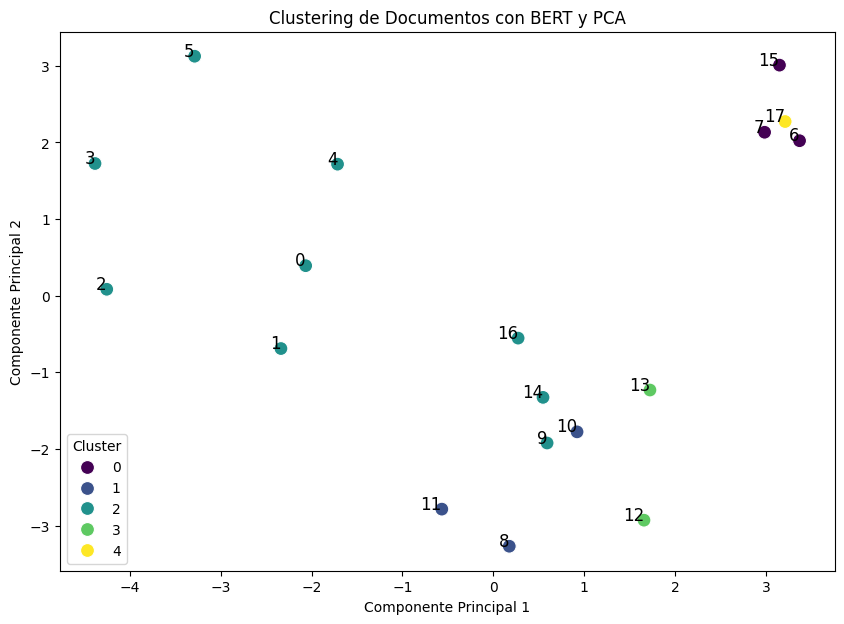

In [ ]:
# =====================================================
# 🔹 SECCIÓN 5: Reducción de Dimensiones con PCA 🔹
# =====================================================
"""
# 📌 **Reducción de Dimensiones con PCA**
Reducimos los embeddings de **768D a 2D** para visualizar los clusters.
"""

# --- 📌 Aplicar PCA ---
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# =====================================================
# 🔹 SECCIÓN 6: Visualización de Clusters 🔹
# =====================================================
"""
# 📌 **Visualización de Clusters en 2D**
Mostramos un gráfico donde:
- **Cada punto representa un documento**.
- **Los colores indican los clusters generados por KMeans**.
"""

# --- 📌 Crear gráfico ---
plt.figure(figsize=(10, 7))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=labels, palette="viridis", s=100)

# --- 📌 Agregar etiquetas con los textos originales ---
for i, txt in enumerate(documentos):
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], str(i), fontsize=12, ha='right')

plt.title("Clustering de Documentos con BERT y PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster")
plt.show()
